# Model Development and Experimentation
  
**Objective**
- Models - `LinearRegression`, `RandonForest`, `XGBoost`
- Build Separate Models per `zone`
- Build Multi-zone model
- Compare with Single models per zone with multi zone model

### import libraries

In [1]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mlflow
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Ensure the common module can be imported
# Adjust the path to point to the common directory
# Get the parent directory of the project (one level above week-2/)
sys.path.append(os.path.abspath(".."))

from common.load_data import load_data
from common.time_based_features import add_time_based_features
from common.lag_and_rolling_statistics import engineer_lag_and_rolling
from common.scale_features import scale_features
from common.chronological_split import chronological_train_test_split
from common.linear_regression import baseline_model_performance
from common.persistence_model import persistence_baseline_performance



In [2]:
def plot_actual_vs_predicted_models(results, df_test, zones, datetime_col='DateTime_Copy'):
    """
    Creates separate plots for Actual and Predicted per model for each zone,
    with consistent colors across zones.
    """
    # Ensure datetime column is datetime type
    if not pd.api.types.is_datetime64_any_dtype(df_test[datetime_col]):
        df_test[datetime_col] = pd.to_datetime(df_test[datetime_col])
    
    datetime_values = df_test[datetime_col]

    # Define consistent colors for each model
    model_colors = {
        'LinearRegression': 'red',
        'RandomForest': 'blue',
        'XGBoost': 'green'
    }

    model_types = list(model_colors.keys())

    for zone in zones:
        for model_type in model_types:
            # Find the key in results matching this zone and model_type
            model_name = next((k for k in results if k.startswith(model_type) and zone in k), None)
            if model_name:
                preds = results[model_name]['predictions']

                # ---- Plot 1: Actual only ----
                plt.figure(figsize=(14,5))
                plt.plot(datetime_values, df_test[zone], 
                         label='Actual', color='black', linewidth=2)
                plt.title(f'Actual {zone}  {zone} using {model_name}', fontsize=16)
                plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
                plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
                plt.xticks(rotation=45)
                plt.xlabel('Datetime')
                plt.ylabel(zone)
                plt.legend()
                plt.grid(alpha=0.3)
                plt.tight_layout()
                plot_path_actual = f"{model_name}_{zone}_actual.png"
                plt.savefig(plot_path_actual)
                plt.show()
                plt.close()
                mlflow.log_artifact(plot_path_actual, artifact_path="plots")

                # ---- Plot 2: Predicted only ----
                plt.figure(figsize=(14,5))
                plt.plot(datetime_values, preds, 
                         label=f'Predicted ({model_type})', 
                         color=model_colors[model_type], linewidth=2)
                plt.title(f'Predicted {zone} using {model_name}', fontsize=16)
                plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
                plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
                plt.xticks(rotation=45)
                plt.xlabel('Datetime')
                plt.ylabel(zone)
                plt.legend()
                plt.grid(alpha=0.3)
                plt.tight_layout()
                plot_path_pred = f"{model_name}_{zone}_predicted.png"
                plt.savefig(plot_path_pred)
                plt.show()
                plt.close()
                mlflow.log_artifact(plot_path_pred, artifact_path="plots")


def plot_actual_vs_predicted_models_old(results, df_test, zones, datetime_col='DateTime_Copy'):
    """
    Plots actual vs predicted per model for each zone, with consistent model colors across zones.
    
    Parameters:
    - results: dict of model results with predictions
    - df_test: pd.DataFrame of test data
    - zones: list of target zone columns
    - datetime_col: datetime column for x-axis
    """
    # Ensure datetime column is datetime type
    if not pd.api.types.is_datetime64_any_dtype(df_test[datetime_col]):
        df_test[datetime_col] = pd.to_datetime(df_test[datetime_col])
    
    datetime_values = df_test[datetime_col]

    # Define consistent colors for each model
    model_colors = {
        'LinearRegression': 'red',
        'RandomForest': 'blue',
        'XGBoost': 'green'
    }

    # Extract unique model types from results
    model_types = list(model_colors.keys())

    for zone in zones:
        for model_type in model_types:
            # Find the key in results matching this zone and model_type
            model_name = next((k for k in results if k.startswith(model_type) and zone in k), None)
            if model_name:
                preds = results[model_name]['predictions']
                
                plt.figure(figsize=(14,5))
                plt.title(f'{zone} - {model_type}', fontsize=16)
                
                # Plot actual
                plt.plot(datetime_values, df_test[zone], label='Actual', color='black', linewidth=2)
                
                # Plot predicted with consistent color
                plt.plot(datetime_values, preds, label=model_type, 
                         color=model_colors[model_type], linestyle='--', linewidth=1.5)
                
                # Format x-axis
                plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
                plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
                plt.xticks(rotation=45)
                
                plt.xlabel('Datetime')
                plt.ylabel(zone)
                plt.title(f'Actual vs Predicted for {zone} using {model_name}')
                plt.legend()
                plt.grid(alpha=0.3)
                plt.tight_layout()
                plot_path = f"{model_name}_{zone}_plot.png"
                plt.savefig(plot_path)
                plt.show()
                plt.close()

                mlflow.log_artifact(plot_path, artifact_path="plots")

In [3]:
zones = [
    'Zone 1 Power Consumption',
    'Zone 2 Power Consumption',
    'Zone 3 Power Consumption'
]

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, tree_method='hist')
}

results = {}

# ---------- Load & base features (no lags yet) ----------
dataset = (
    load_data(file_path=r'..\Data\Tetuan City power consumption.csv')
    .pipe(add_time_based_features)
)

dataset_full = dataset.copy()

# ---------- Chronological split BEFORE lags/rolling ----------
dataset_train, dataset_test = chronological_train_test_split(
    dataset_full, train_ratio=0.8, val_ratio=None
)




[INFO] Using 'DateTime' as datetime index column


In [4]:
for zone in zones:    # Feature engineering ONLY for this zone
    train_zone = engineer_lag_and_rolling(dataset_train, zone, lags=[1], rolling_windows=[3])
    test_zone  = engineer_lag_and_rolling(dataset_test,  zone, lags=[1], rolling_windows=[3])

    train_scaled, test_scaled, scaler, feature_cols = scale_features(
        train_zone, test_zone, target_col=zone
    )

    X_train = train_scaled[feature_cols]
    y_train = train_scaled[zone]

    X_test = test_scaled[feature_cols]
    y_test = test_scaled[zone]

    for name, model in models.items():
        with mlflow.start_run(run_name=f"{name}_{zone}"):
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
        
            rmse = np.sqrt(mean_squared_error(y_test, preds))
            mae = mean_absolute_error(y_test, preds)
            r2 = r2_score(y_test, preds)
            
            # Log parameters (basic ones)
            if hasattr(model, "get_params"):
                mlflow.log_params(model.get_params())

            # Log metrics
            mlflow.log_metric("RMSE", rmse)
            mlflow.log_metric("MAE", mae)
            mlflow.log_metric("R2", r2)

            results[f'{name}_{zone}'] = {"RMSE": rmse, "MAE": mae, "R2": r2, "predictions": preds}

            metrics_df = pd.DataFrame({k: {m:v for m,v in v.items() if m!="predictions"} 
                            for k,v in results.items()}).T
            mlflow.sklearn.log_model(model, name="model", input_example=X_train.head(5))

print(metrics_df)


2025/08/28 12:58:19 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



                                                 RMSE         MAE        R2
LinearRegression_Zone 1 Power Consumption  454.367351  339.725092  0.994571
RandomForest_Zone 1 Power Consumption      253.664487  141.597709  0.998308
XGBoost_Zone 1 Power Consumption           286.385669  174.278265  0.997843
LinearRegression_Zone 2 Power Consumption  379.034880  285.118287  0.995222
RandomForest_Zone 2 Power Consumption      232.998207  127.545364  0.998195
XGBoost_Zone 2 Power Consumption           255.432781  156.436257  0.997830
LinearRegression_Zone 3 Power Consumption  291.706884  211.576803  0.992183
RandomForest_Zone 3 Power Consumption      332.082266  149.777684  0.989869
XGBoost_Zone 3 Power Consumption           415.890434  217.058321  0.984111


**Zone 1**
| Model            | RMSE   | MAE    | R²     |
| ---------------- | ------ | ------ | ------ |
| LinearRegression | 454.37 | 339.73 | 0.9946 |
| RandomForest     | 253.66 | 141.60 | 0.9983 |
| XGBoost          | 286.39 | 174.28 | 0.9978 |
  

**Zone 2**
| Model            | RMSE   | MAE    | R²     |
| ---------------- | ------ | ------ | ------ |
| LinearRegression | 379.03 | 285.12 | 0.9952 |
| RandomForest     | 232.99 | 127.55 | 0.9982 |
| XGBoost          | 255.43 | 156.44 | 0.9978 |


**Zone 3**
| Model            | RMSE   | MAE    | R²     |
| ---------------- | ------ | ------ | ------ |
| LinearRegression | 291.71 | 211.58 | 0.9922 |
| RandomForest     | 332.08 | 149.78 | 0.9899 |
| XGBoost          | 415.89 | 217.06 | 0.9841 |


- **RandomForest**: most consistent performer, expcially for Zones 1 & 2
- **XGBoost**: may require tuning (learning_rate, n_estimators, max_depth)
  - XGBoost builds trees sequentially, each one correcting the previous errors.
  - learning_rate controls how strongly each tree influences the final prediction.
  - n_estimators controls how many trees are built.
  - max_depth controls how complex each tree can be.
- **Zone 3**: behaves differently - might need custom features or lags to capture dynamics
- **Linear Regression**: is strong - indicating time based + lag features capture linear relationships

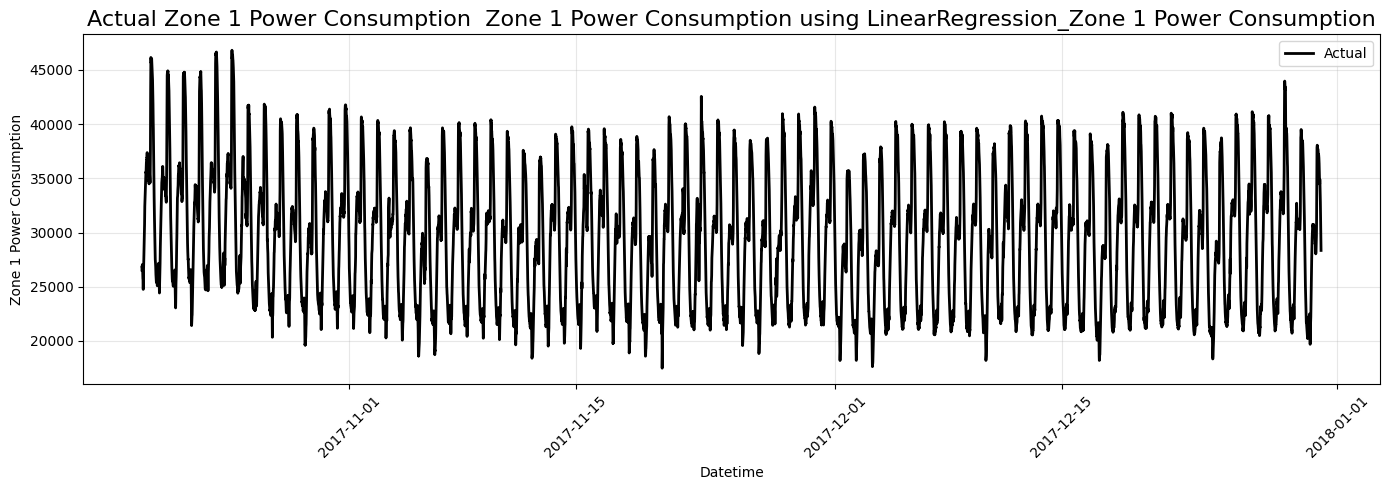

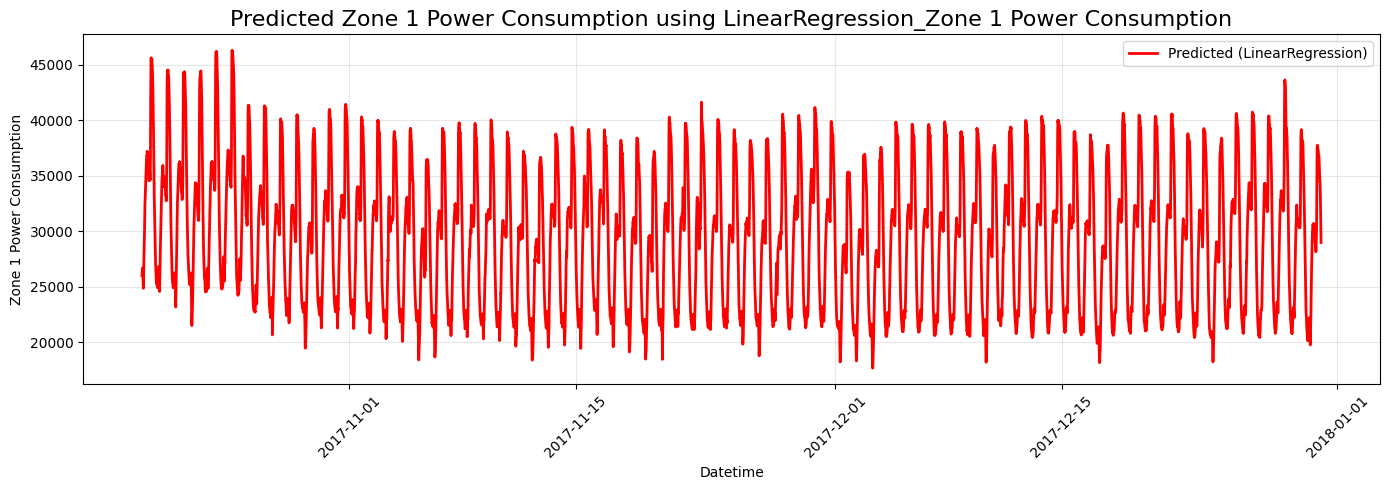

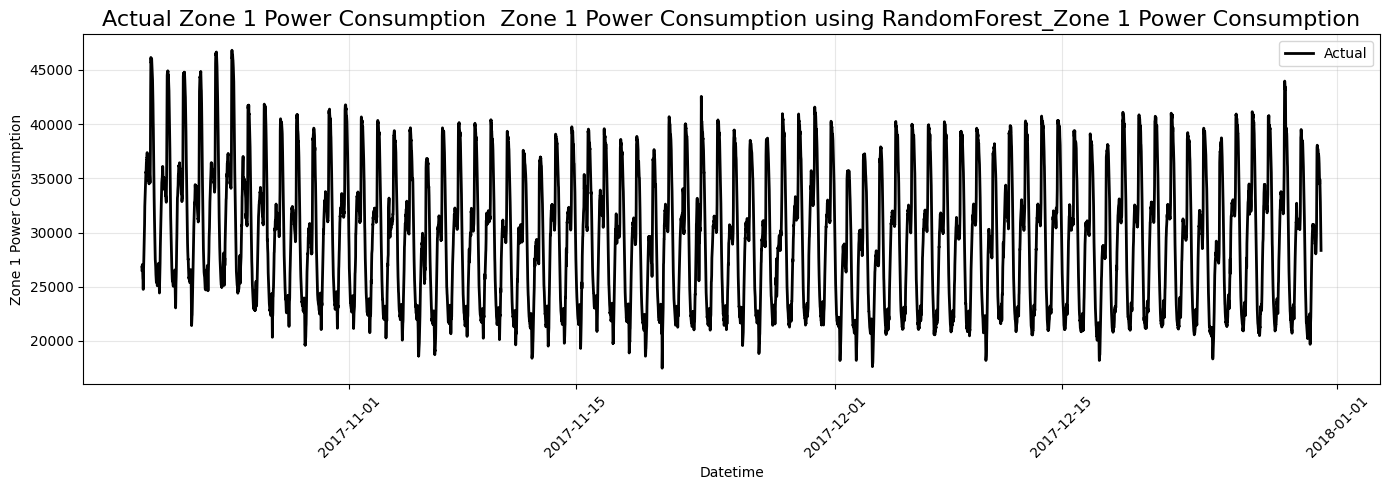

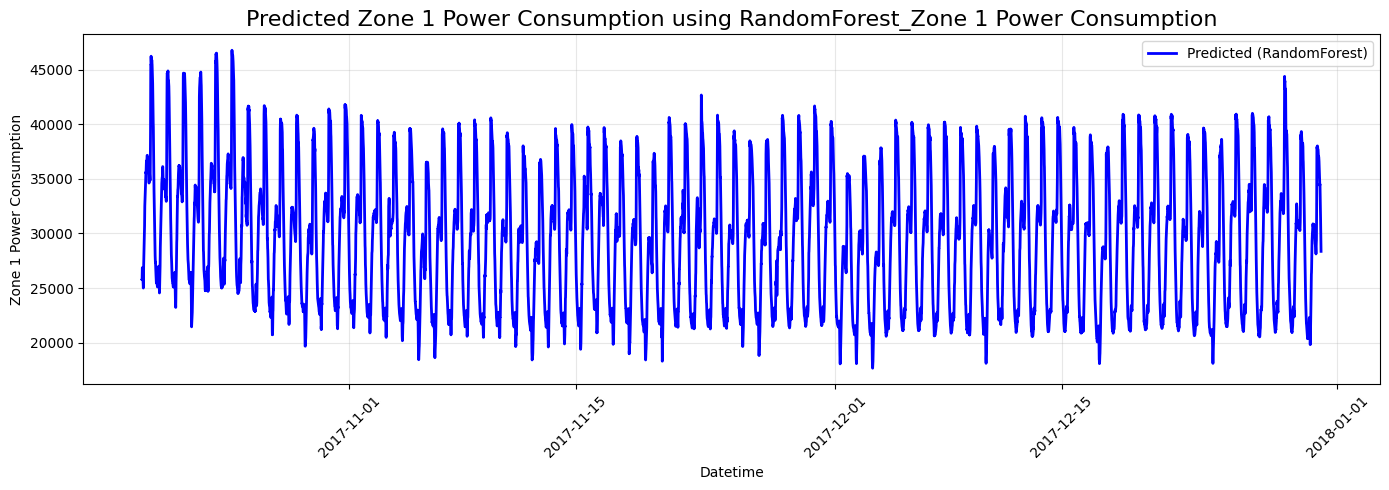

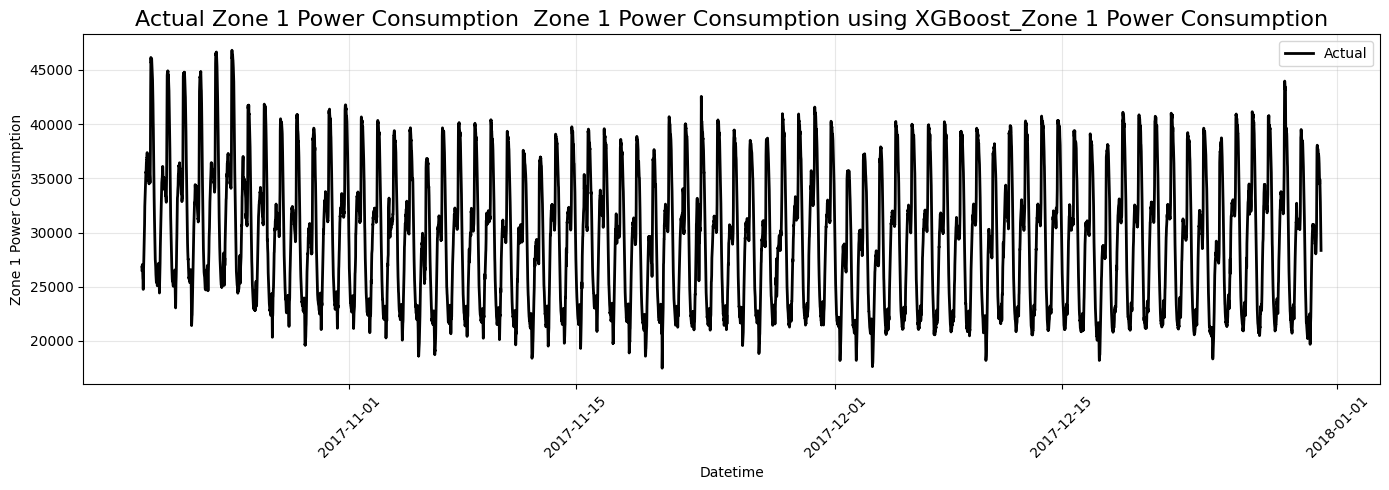

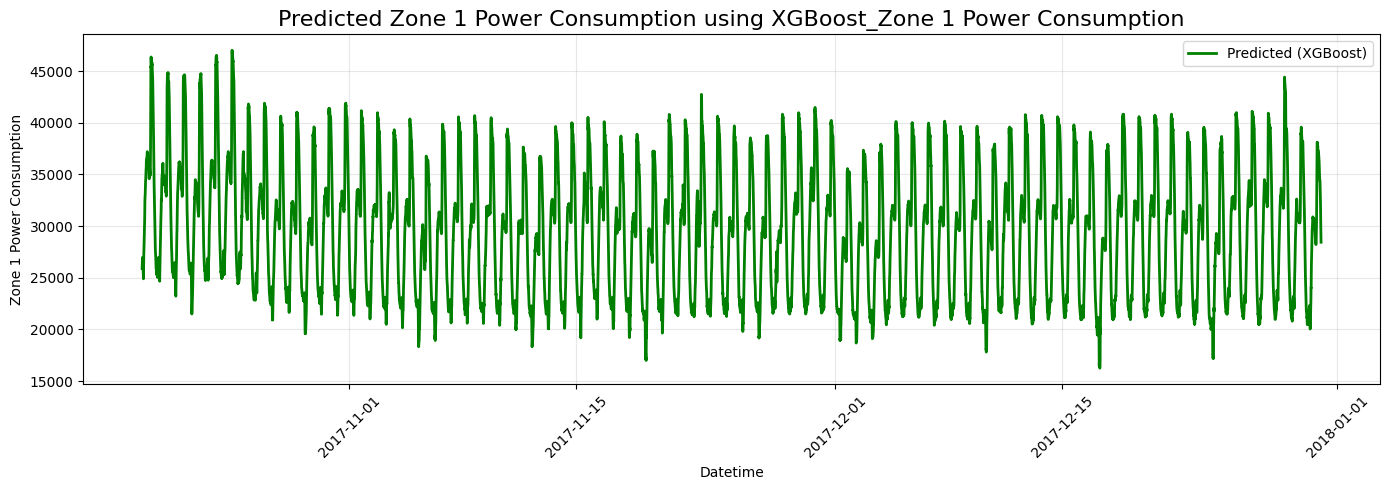

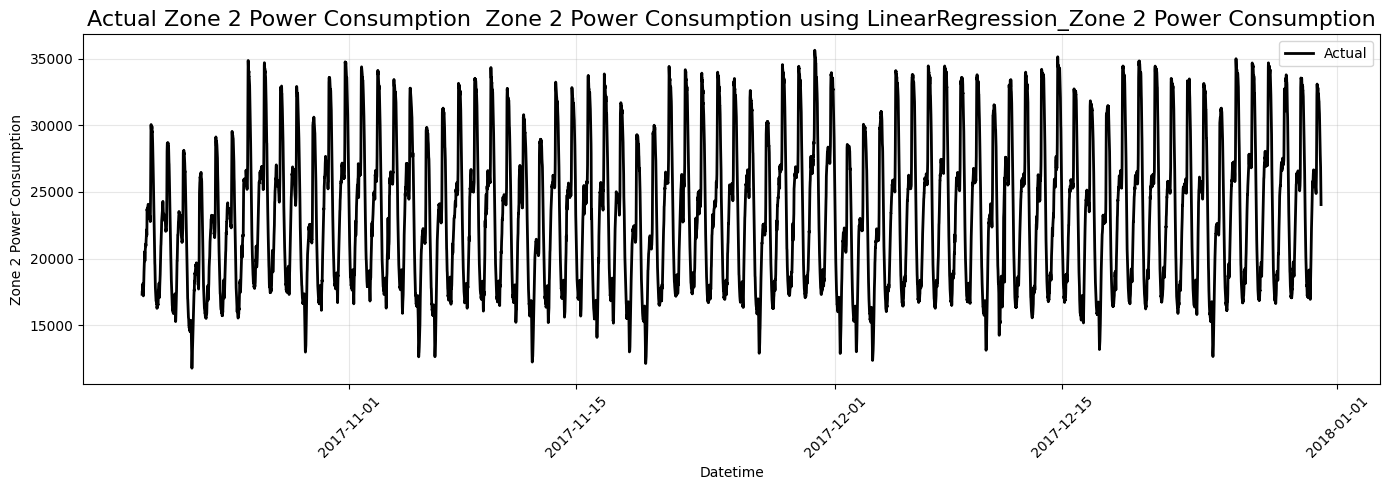

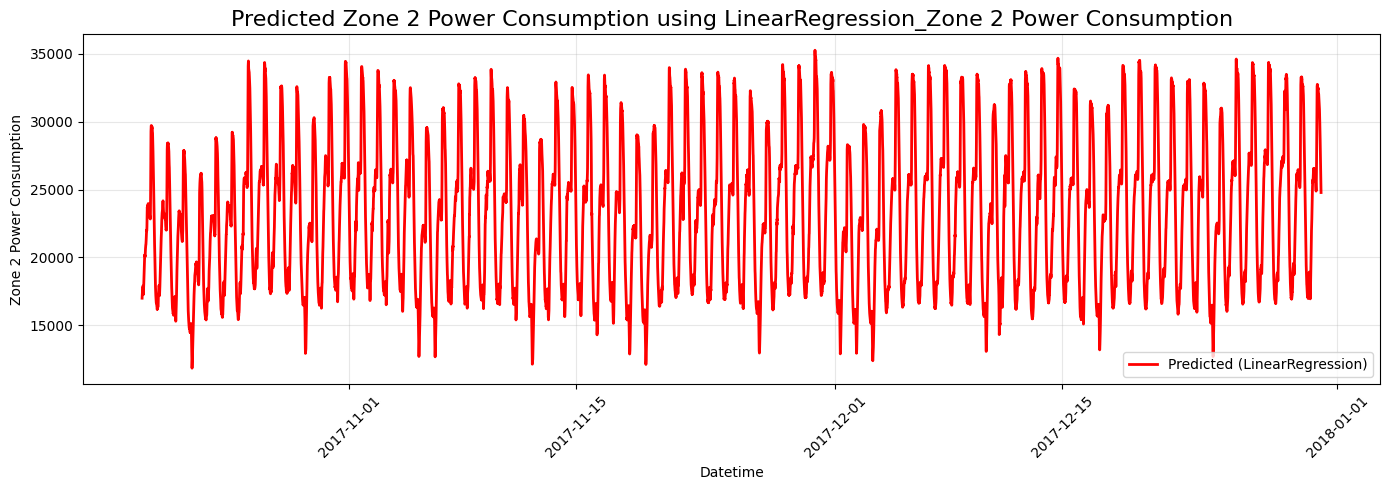

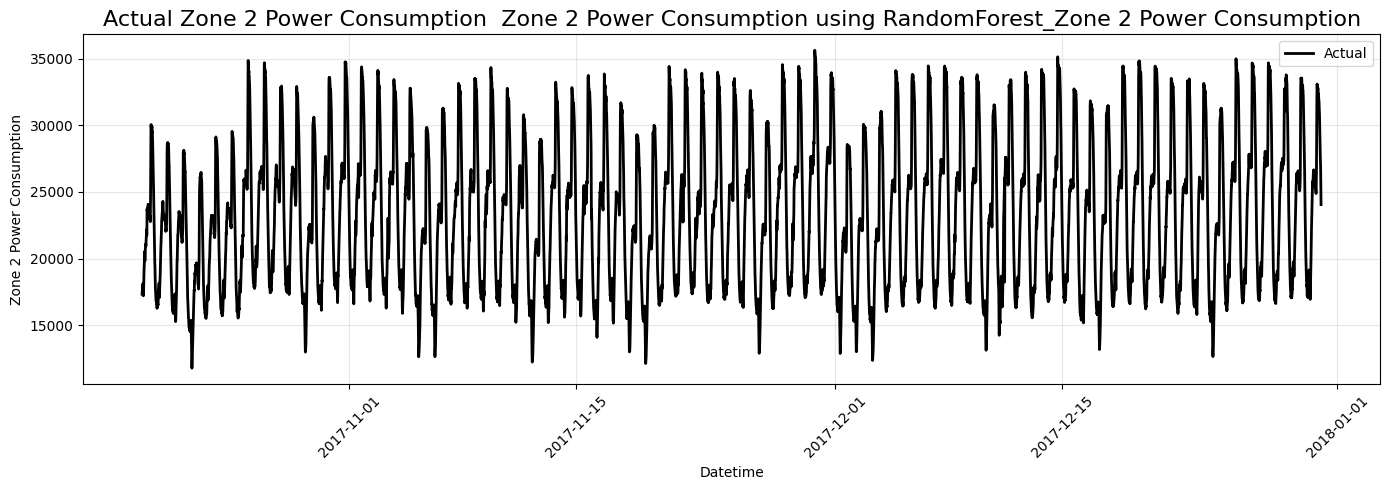

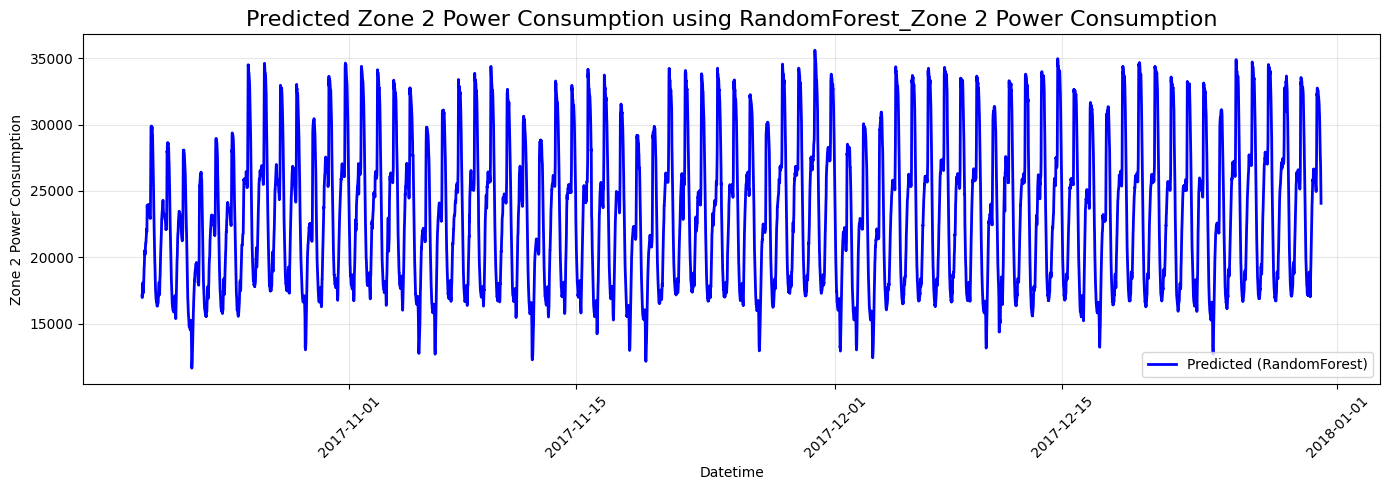

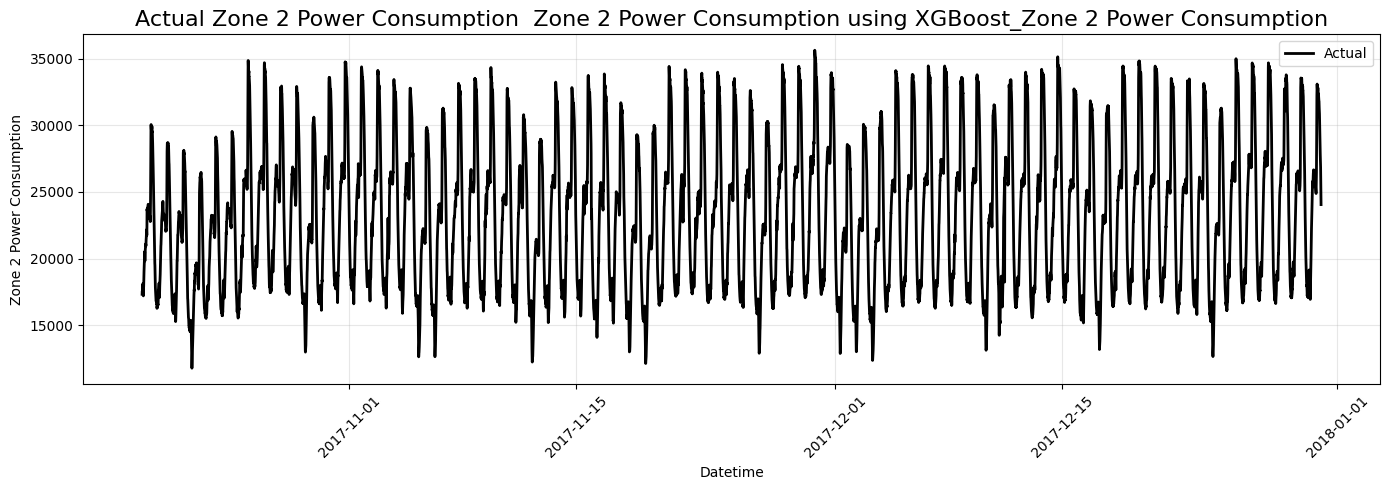

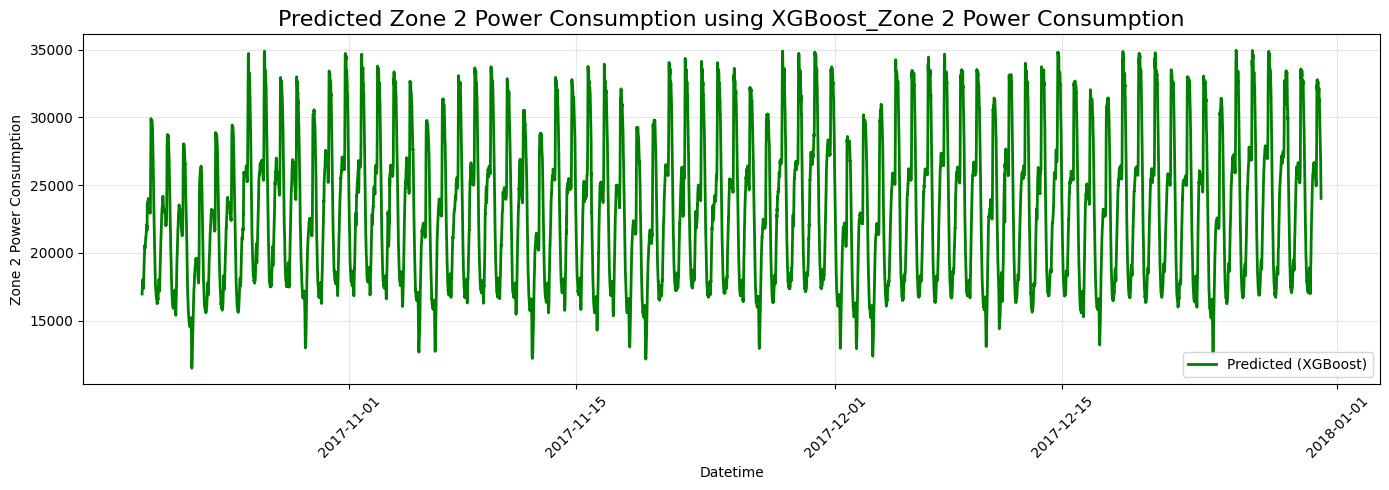

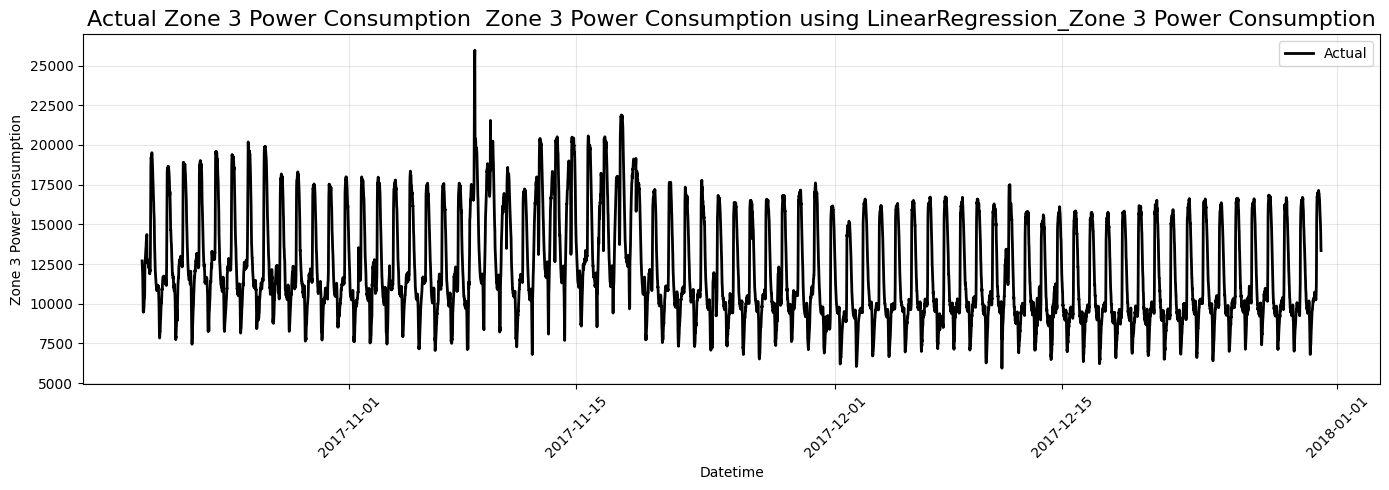

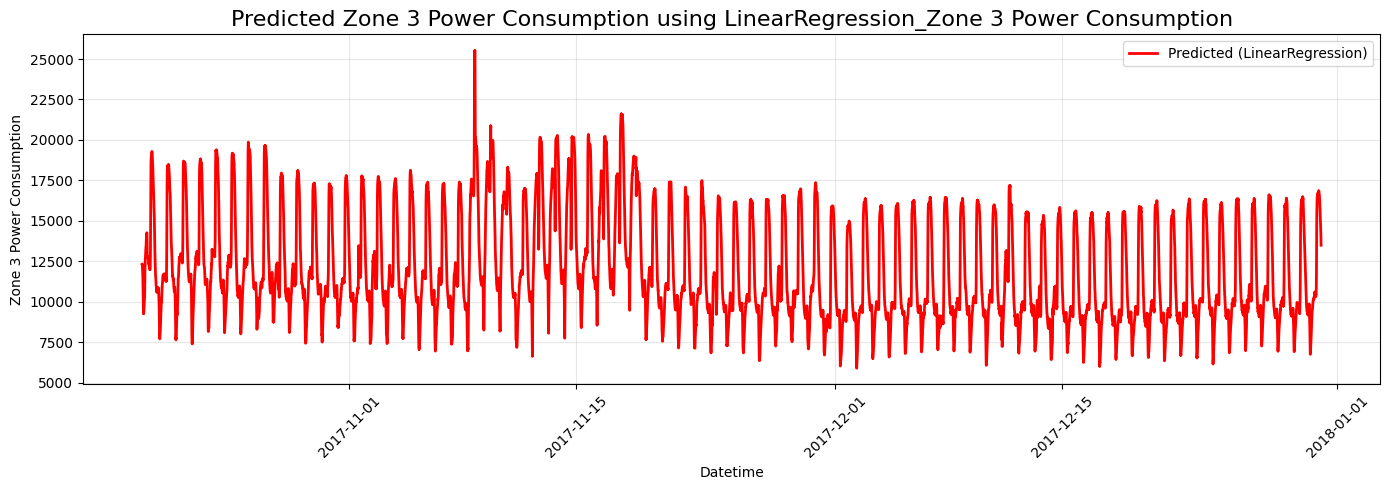

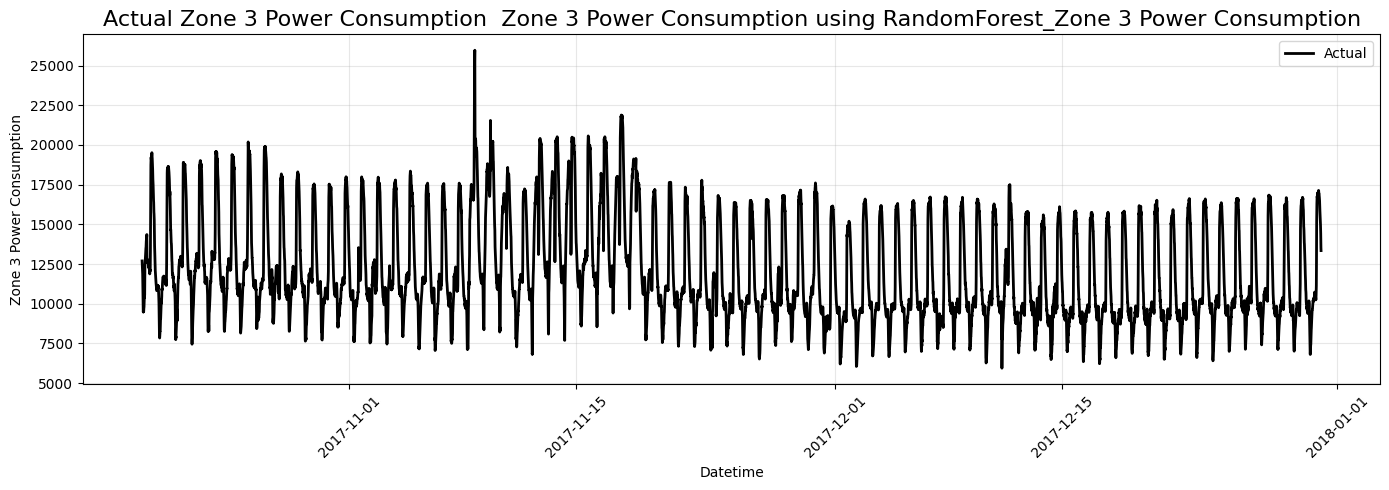

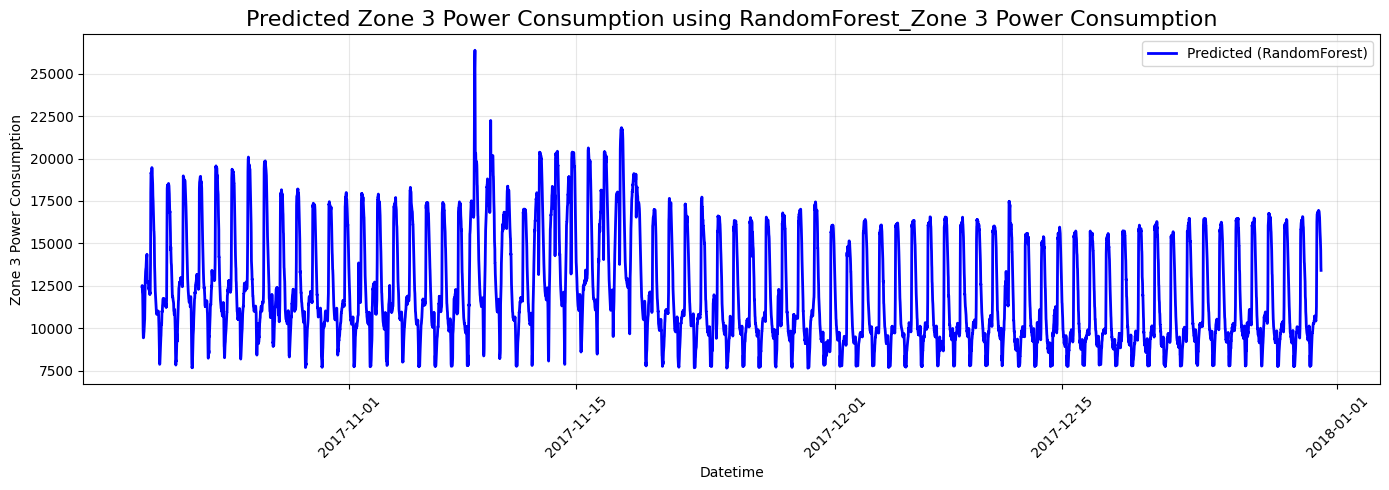

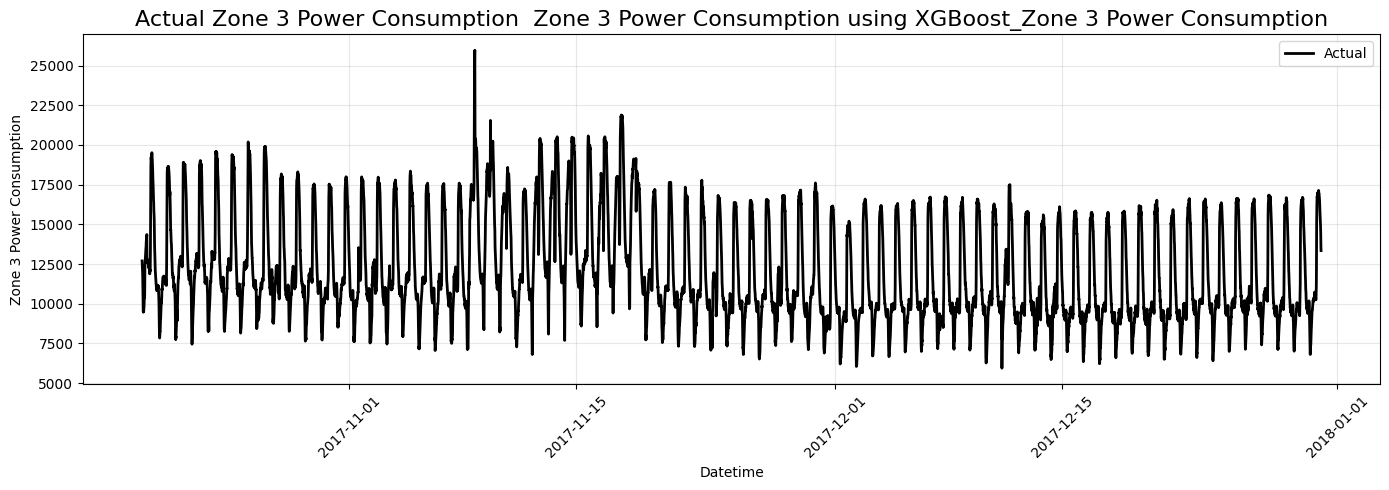

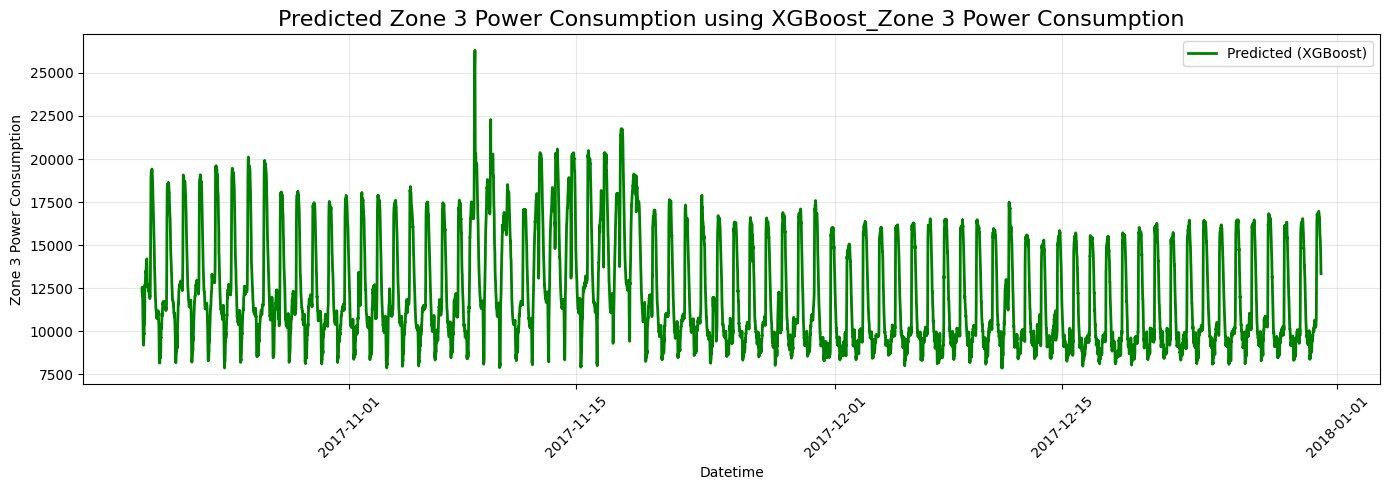

In [5]:
plot_actual_vs_predicted_models(results, test_scaled, zones)